In [67]:
%matplotlib inline

from astropy.nddata import NDData, CCDData, Cutout2D, StdDevUncertainty
from astropy.wcs import WCS
from astropy import modeling
# import lmfit
import numpy as np
import matplotlib.pyplot as plt

from photutils import DAOStarFinder

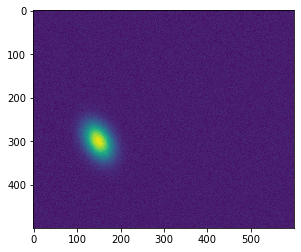

In [13]:
x, y = np.mgrid[0:500, 0:600]
# np.exp(-x ** 2 - y**2)
model = modeling.models.Gaussian2D(
    amplitude=0.5,
    x_mean=300, y_mean=150,
    x_stddev=30, y_stddev=20,
    theta=0.5,
)
data = model(x, y) + 0.01 * np.random.normal(size=x.shape)

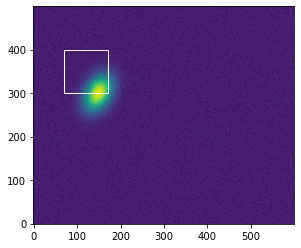

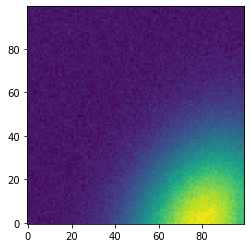

In [25]:
plt.imshow(data, origin='lower')
nddata = NDData(data)
cutout = Cutout2D(data, (120.6, 350.1), (100, 100))
cutout.plot_on_original(color='w')
plt.figure()
plt.imshow(cutout.data, origin='lower')

In [43]:
nddata = NDData([1, 2, 3, 4, 5],
                uncertainty=StdDevUncertainty([0.1, 0.5, 0.5, 0.6, 0.4]))
nddata 

NDData([1, 2, 3, 4, 5])

/opt/conda/lib/python3.7/site-packages/astropy/io/fits/verify.py:117: VerifyWarning: Verification reported errors:
  warnings.warn(line, VerifyWarning)
/opt/conda/lib/python3.7/site-packages/astropy/io/fits/verify.py:117: VerifyWarning: Card 'SWCREATE' is not FITS standard (invalid value string: 'SkyCam(Linux)      / Name of software that created the image').  Fixed 'SWCREATE' card to meet the FITS standard.
  warnings.warn(line, VerifyWarning)
/opt/conda/lib/python3.7/site-packages/astropy/io/fits/verify.py:117: VerifyWarning: Note: astropy.io.fits uses zero-based indexing.

  warnings.warn(line, VerifyWarning)
/opt/conda/lib/python3.7/site-packages/astropy/io/fits/verify.py:117: VerifyWarning: Card 'PROGECT' is not FITS standard (invalid value string: 'MASTER-SAAO').  Fixed 'PROGECT' card to meet the FITS standard.
  warnings.warn(line, VerifyWarning)
/opt/conda/lib/python3.7/site-packages/astropy/io/fits/verify.py:117: VerifyWarning: Card 'CUNIT2' is not FITS standard (invalid value

(0, 256)

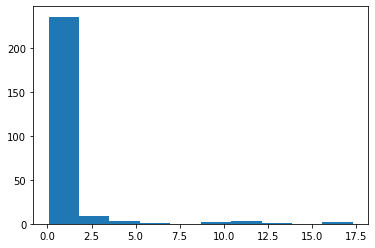

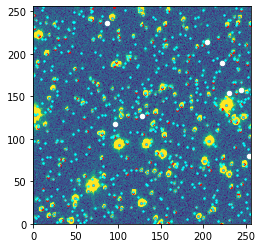

In [118]:
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
import astropy.units as u

from astroquery.gaia import Gaia

master_fits = fits.open('MASTER.fit')
data = master_fits[0].data
wcs = WCS(master_fits[0].header)

mean, median, std = sigma_clipped_stats(data, sigma=3)
star_finder = DAOStarFinder(threshold=3 * std, fwhm=3)
pixel_stars = star_finder(data - median)
stars = SkyCoord.from_pixel(pixel_stars['xcentroid'],
                            pixel_stars['ycentroid'],
                            wcs=wcs)

lower_left = SkyCoord.from_pixel(0, 0, wcs=wcs)
upper_right = SkyCoord.from_pixel(data.shape[0] - 1, data.shape[0] - 1,
                                  wcs=wcs)
diag = upper_right.separation(lower_left)
center = SkyCoord.from_pixel(data.shape[0] // 2, data.shape[0] // 2,
                                  wcs=wcs)
gaia_job = Gaia.cone_search(center, radius=diag / 2)
gaia_table = gaia_job.get_results()
# display(gaia_table)
gaia_coords = SkyCoord(ra=gaia_table['ra'], dec=gaia_table['dec'])
gaia_pixels = gaia_coords.to_pixel(wcs)

idx_gaia, d2d, _ = stars.match_to_catalog_sky(gaia_coords)
outliers = pixel_stars[d2d > 8 * u.arcsec]

plt.hist(d2d.to_value('arcsec'))

plt.figure()
plt.imshow(data, origin='lower',
           norm=LogNorm(vmax=np.percentile(data, 95)))
plt.scatter(pixel_stars['xcentroid'], pixel_stars['ycentroid'],
            marker='*', color='red', s=4)
plt.scatter(outliers['xcentroid'], outliers['ycentroid'],
            color='white', s=20)
plt.scatter(*gaia_pixels, marker='o', color='cyan', s=2)
plt.xlim(0, data.shape[0])
plt.ylim(0, data.shape[1])

In [101]:

from astroquery.simbad import Simbad

Simbad.query_object('M87')

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
M 87,12 30 49.4233,+12 23 28.043,12,12,0.041,0.043,90,A,R,2015AJ....150...58F
